In [1]:
from openbb import obb
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
obb.account.login(email = "your_email_here", password = "your_password_here", remember_me = True)

In [4]:
data = obb.equity.price.historical('AAPL').to_df()  # Example for Apple's daily data

data.tail(5)

,open,high,low,close,volume,vwap,label,adj_close,unadjusted_volume,change,change_percent,change_over_time
date,,,,,,,,,,,,
2023-12-19,196.16,196.95,195.89,196.9400,40714051,196.53,"December 19, 23",196.9400,40714100.0,0.7800,0.397630,0.003976
2023-12-20,196.90,197.68,194.83,194.8300,52242815,196.14,"December 20, 23",194.8300,52242800.0,-2.0700,-1.050000,-0.010500
2023-12-21,196.10,197.08,193.50,194.6800,46482549,194.74,"December 21, 23",194.6800,46482500.0,-1.4200,-0.724120,-0.007241
2023-12-22,195.18,195.41,192.97,193.6000,36968027,194.10,"December 22, 23",193.6000,35779848.0,-1.5800,-0.809510,-0.008095
2023-12-26,193.61,193.89,192.89,193.0801,9178367,193.29,"December 26, 23",193.0801,9178367.0,-0.5299,-0.273695,-0.002737


Cumulative Returns: $287.25


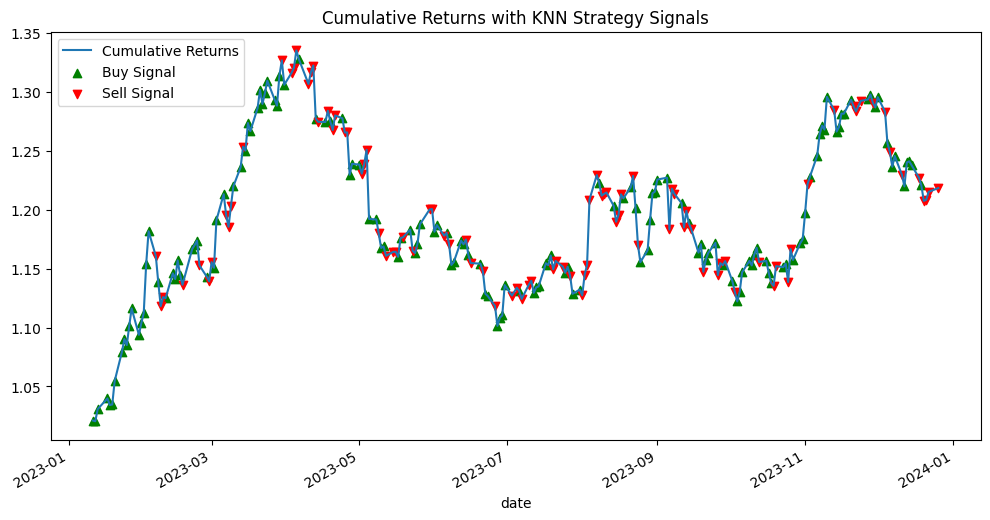

In [13]:
# Prepare data for KNN
data['Returns'] = data['close'].pct_change()
data.dropna(inplace=True)
X = data[['open', 'high', 'low', 'close']]
y = data['Returns'] > 0  # Classifying as positive or negative return

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and fit KNN model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_scaled, y)

# Generate trading signals (1 = buy, -1 = sell)
data['Signal'] = model.predict(X_scaled)
data['Signal'] = data['Signal'].map({True: 1, False: -1})

# Calculate strategy returns
data['Strategy_Returns'] = data['Returns'] * data['Signal'].shift(1)

# Calculate cumulative returns
data['Cumulative_Returns'] = (1 + data['Strategy_Returns']).cumprod()

cumulative_returns = data['Cumulative_Returns'].sum()
print(f"Cumulative Returns: ${cumulative_returns:.2f}")

# Plotting cumulative returns and signals for visualization
plt.figure(figsize=(12, 6))
data['Cumulative_Returns'].plot(label='Cumulative Returns')
plt.scatter(
    data[data['Signal'] == 1].index,
    data[data['Signal'] == 1]['Cumulative_Returns'],
    marker='^',
    color='g',
    label='Buy Signal',
    alpha=1
)
plt.scatter(
    data[data['Signal'] == -1].index,
    data[data['Signal'] == -1]['Cumulative_Returns'],
    marker='v',
    color='r',
    label='Sell Signal',
    alpha=1
)
plt.title('Cumulative Returns with KNN Strategy Signals')
plt.legend()
plt.show()
